Preliminary Cosumnes Model Spin up
Michigan Bar to lower Rooney Ranch
Created on Thu Apr  2 17:59:11 2020

@author: Andrew

In [1]:
# For grid creation
import os
import sys
import numpy as np
# run installed version of flopy or add local path
try:
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference

import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import pyproj # for converting proj4string
import pandas as pd

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in C:\Users\ajcalder\anaconda3\envs\py36\lib\site-packages\flopy



Bad key "text.kerning_factor" on line 4 in
C:\Users\ajcalder\anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 17:58:33) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.0


In [51]:
# Spatial discretization
nrow = 130
ncol = 200
delr = 100
delc = 100
nlay = 5

# Geo reference, utm zone 10n
xoff=660000
yoff=4248000
angrot=53

# Time discretization
nper = 1
perlen = [1] # days
nstp = [10]
steady = [True]

According to Flopy GitHub "Technically you need to create both a SpatialReference object and a ModelGrid object, but in practice the code looks very similar and can easily be implemented in one line."
WGS84 Zone 10N has EPSG: 32610  
Lower left corner of model is   
Zone 10 N  
Easting: 661211.18 m E  
Northing: 4249696.50 m N  
angle is approximate 53 degrees  

In [52]:
m = flopy.modflow.Modflow(modelname = 'Basic_Cosumnes', exe_name = 'mf2005', 
                          version = 'mf2005', model_ws='data')

botm = np.zeros((nlay, nrow, ncol))
# Layer 1: Sandy Mud - Mud, Layer 2: Sandy Mud - Gravel, Layer 3: Mud- Sandy Mud, Layer 4: Sandy Mud - Gravel Layer 5: Mud
lthick = [5,5,10,10,5] # Layer 1 is bottom of top layer, layer 5 is bottom of bottom layer
elev = 0
for i in np.arange(0,nlay):
    elev = elev- lthick[i]
    botm[i, :, :] = elev

#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               top=3, botm=botm, model=m, lenuni = 2, itmuni = 4,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady)

In [53]:
grid = m.modelgrid
grid.set_coord_info(xoff=xoff, yoff=yoff, proj4='EPSG:32610', angrot=angrot)
chk = dis.check()
chk.summary_array
mg = m.modelgrid


DIS PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative thickness
    thin cells (less than checker threshold of 1.0)
    nan values in top array
    nan values in bottom array



## Grid lines

In [5]:
def plot_lines(lines):
    fig, ax = plt.subplots()
    for ln in lines:
        plt.plot([ln[0][0], ln[1][0]], [ln[0][1], ln[1][1]])

In [6]:
# Import location of sensors
spath = "C://Users/ajcalder/Box/Research_Calderwood/dem"
df = pd.read_csv(spath+"/allsensor_latlong.csv", parse_dates = True, 
                index_col = 0, sep = ',', header = 'infer')

lat = df.Latitude.values
lon = df.Longitude.values

In [7]:
# Change project of sensor locations
crs_wgs = pyproj.CRS("epsg:4326")
crs_utm = pyproj.CRS("epsg:32610")
transformer = pyproj.Transformer.from_crs(crs_wgs, crs_utm, always_xy = True)
# Convert WGS Lat and long to Easting and Northing in Zone 10N
east, north = transformer.transform(lon,lat)

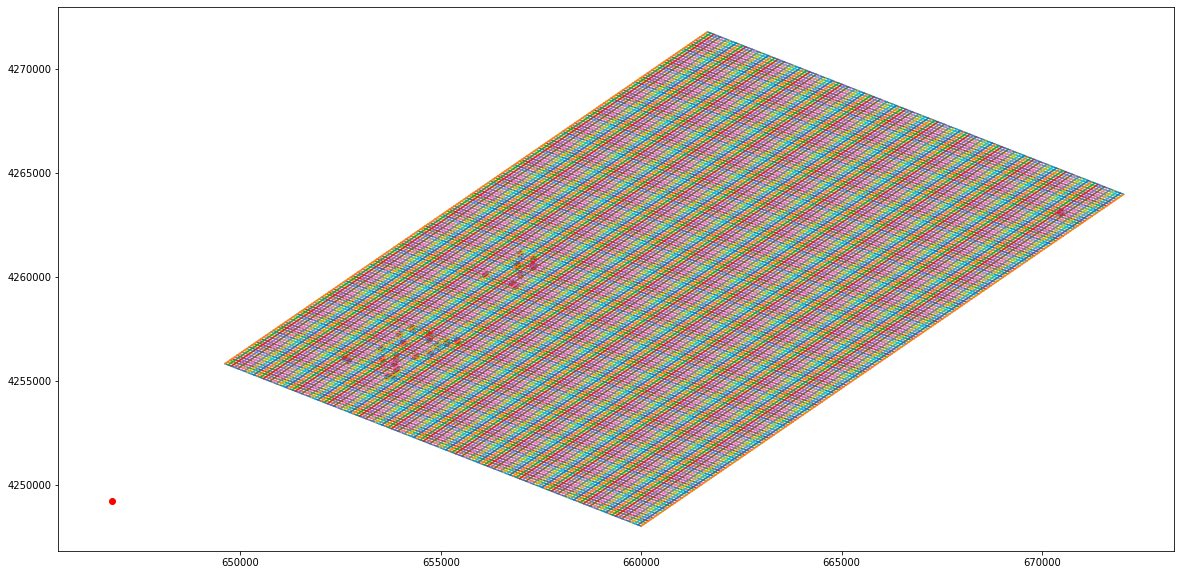

In [8]:
# Plot the basic model grid and sensors
plt.rcParams["figure.figsize"] = (20,10)
fig = plot_lines(mg.grid_lines)
# plot_lines(mg.grid_lines)
plt.scatter(east, north, c='r')


In [10]:
# Get vertexes of model domain
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(nrow*delr, 0) #lower right
ur = mg.get_coords(nrow*delr, ncol*delc) #upper right
ul = mg.get_coords(0, ncol*delc) #upper left
print(ll, lr, ur, ul)

# Shapefile of model bounds
vertices = np.stack(np.asarray((ll,lr, ur, ul)))
vertices

(660000.0, 4248000.0) (667823.5953009767, 4258382.261630615) (651850.8851000308, 4270418.5620936565) (644027.2897990542, 4260036.300463041)


array([[ 660000.        , 4248000.        ],
       [ 667823.59530098, 4258382.26163062],
       [ 651850.88510003, 4270418.56209366],
       [ 644027.28979905, 4260036.30046304]])

In [14]:
# For raster intersect
import time
import shapely
import shapefile

try:
    import flopy
    from flopy.utils import Raster
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    from flopy.utils import Raster

### Raster files can be loaded using the `Raster.load` method

In [15]:
# Full size dem of northern sac valley
# raster_name = spath+"/USGS_ten_meter_dem/transformed.tif"
# Raster clipped to model area
raster_name = spath+'/USGS_ten_meter_dem/reduced10m.tif'

rio10_utm = Raster.load(raster_name)

In [19]:
t0 = time.time()
dem_data = rio10_utm.resample_to_grid(m.modelgrid.xcellcenters,
                                m.modelgrid.ycellcenters,
                                band=rio10_utm.bands[0],
                                method="nearest")
resample_time = time.time() - t0
print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

Resample time, nearest neighbor: 28.162 sec


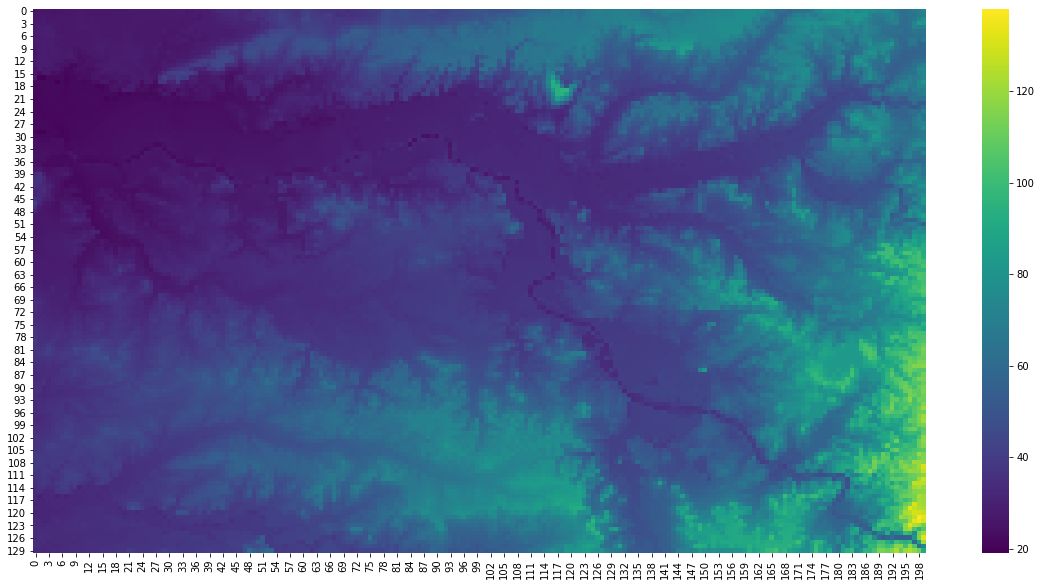

In [20]:
import seaborn as sns
sns.heatmap(dem_data, cmap = 'viridis')


In [54]:
# Set the elevation of the top layer based on the DEM
dis.top = dem_data

# Correct bottom elevations based on top dem
# Keeping layer thickness constant and subtracting thickness from elevation
botm = np.zeros((nlay, nrow, ncol))
lthick = [5,5,10,10,5] # Layer 1 is bottom of top layer, layer 5 is bottom of bottom layer
elev = top_dem
for i in np.arange(0,nlay):
    elev = elev- lthick[i]
    botm[i, :, :] = elev

dis.botm = botm

# Delineate no flow cells

In [107]:
import richdem as rd
raster_name = spath+'/USGS_ten_meter_dem/reduced10m.tif'
dem = rd.LoadGDAL(raster_name)
slope = rd.TerrainAttribute(dem, attrib = 'slope_riserun')


The slope does not provide a meaningful method to delinate no flow cells as the foothills are not clearly contrasted with the valley. Geologic maps will be more useful. As a starting points the upper 1/2 to 1/3 of the model domain is generally more volcanic and will be classified as no flow.

In [55]:
# Specify no flow boundary based on rough approx of geology (upper basin volcanics)
ibound = np.ones([nlay, nrow,ncol])
upper = np.int(ncol*2/3)
ibound[:,:,upper:] = 0
# plt.imshow(ibound)

For CH of top -10 at bottom and top -3.3 at top with start of top-7.5 for the rest model error was below 5%

In [72]:
strt = np.ones((nlay, nrow, ncol), dtype = np.float32)
strt[:,:,:] = mg.top[:,:] - 3.3
# Going to assign constant head values of 10. and 0. to the first
# and last columns (in all layers)
ibound[:, :, 0] = -1 # set constant head
ibound[:, :, upper-1] = -1 # set constant head

strt[:,:,0] = mg.top[:,0]-4 # set lower boundary head to zero at bottom of aquifer
strt[:,:,upper-1] = mg.top[:,-1] - 3.2 # set upper boundary head to regular water table height 20 m bgs

In [73]:
# Basic package, BAS

# ibound < 0 is cosntant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


## Aquifer properties with LPF

In [58]:
# Layer 1: Sandy Mud - Mud, Layer 2: Sandy Mud - Gravel (water), Layer 3: Mud- Sandy Mud, 
# Layer 4: Sandy Mud - Gravel (water)Layer 5: Mud
# [5,5,10,10,5] thickness in meters
hk = [1E-6, 1E-4, 1E-8, 1E-4, 1E-8]
layvka = [0,0,0,0,0] # 0 means vka is vert K, not 0 means vka is ratio of horiz to vert K
vka = hk #being explicit because this will change later
sy = [0.05, 0.1, 0.02, 0.1, 0.02]
ss = [1E-4, 1E-5, 1E-4, 1E-5, 1E-4]
laytyp = [0,0,0,0,0] # 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
#ipakcb = 53 means cell-by-cell budget is saved because it is non zero (default is 53)
lpf = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = vka, sy=sy, ss=ss,
                               laytyp=laytyp, ipakcb=53)


## Output Control

In [59]:
# Output control
spd = {(0,0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

In [60]:
# pcg = flopy.modflow.ModflowPcg(model = m)
# GMG is more successful than pcg which is fine for steady state model
gmg = flopy.modflow.ModflowGmg(model = m)

In [61]:
os.getcwd()

'C:\\Users\\ajcalder\\Documents\\GitHub\\mar_vineyards_modflow\\SFRCosumnes'

## Write the input files

In [74]:
# Writing the MODFLOW data files
m.write_input()

# Run the model

In [75]:
success, buff = m.run_model()

FloPy is using the following  executable to run the model: C:\WRDAPP\MF2005.1_12\bin\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Basic_Cosumnes.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/07 12:36:08

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time st

## Plotting

In [33]:
os.getcwd()

'C:\\Users\\ajcalder\\Documents\\GitHub\\mar_vineyards_modflow\\SFRCosumnes'

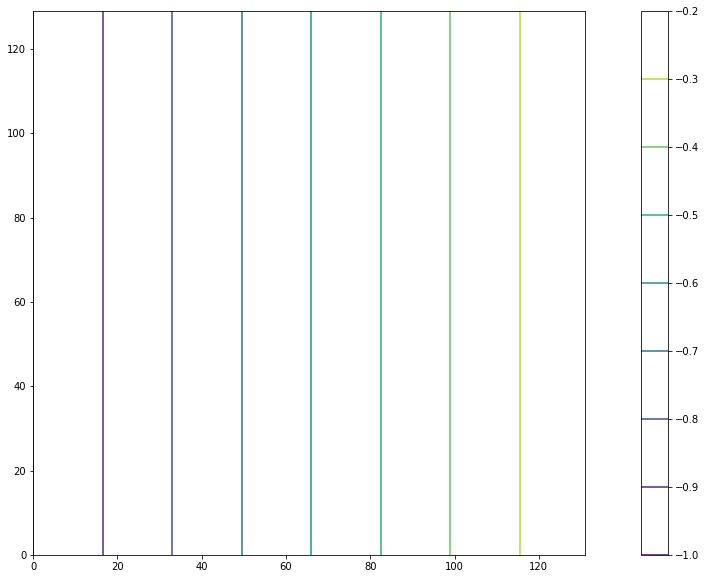

In [103]:
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

## Basic Contour Plot 1a
plt.subplot(1, 1, 1, aspect='equal')
hds = bf.HeadFile('data/' + m.name + '.hds')
# totime is simulation time
# kstpkper tuple of ints = time step and stress period (kstp, kper). These are zero-based kstp and kper values.
head = hds.get_data(totim = 0.1)
# heads is nlay, nrow, ncol
# Need to filter out no flow cells with head of -999.999
head = head[0, :,:upper-1]
levels = np.arange(-10, -1, -1)
extent = (delr / 2., delr*ncol - delr / 2., delc*nrow - delc / 2., delc / 2.)
# plt.contour(head, levels=levels, extent=extent)
plt.contour(head)

plt.colorbar()
# plt.savefig(m.name+'_contour.png')

C:\Users\ajcalder\anaconda3\envs\py36\lib\site-packages\flopy\plot\map.py:333: UserWarning: No contour levels were found within the data range.
  contour_set = ax.tricontour(triang, plotarray, **kwargs)


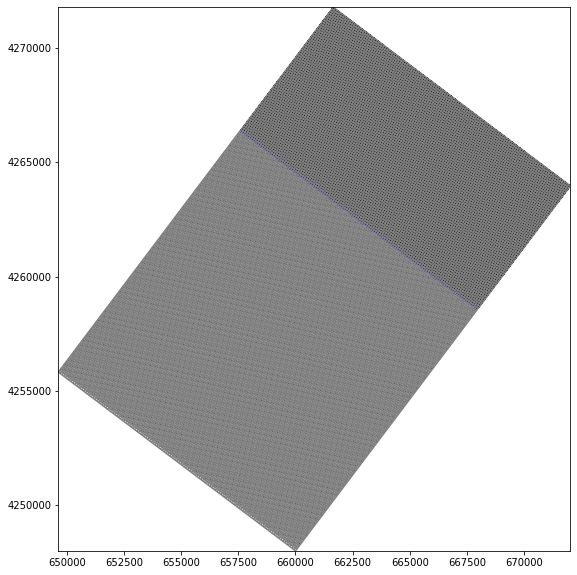

In [94]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

hds = bf.HeadFile('data/' + m.name + '.hds')
times = hds.get_times()
head = hds.get_data(totim=times[-1])
levels = np.linspace(0, 10, 11)

cbb = bf.CellBudgetFile('data/' + m.name + '.cbc')
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

pmv = flopy.plot.PlotMapView(model=m, layer=0)
qm = pmv.plot_ibound()
lc = pmv.plot_grid()
cs = pmv.contour_array(head, levels=levels)
quiver = pmv.plot_discharge(frf, fff, head=head)
# plt.savefig(m.name +'_general.png')